In [2]:
# Importing the libraries needed
import pandas as pd
import torch
import transformers
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, DistilBertTokenizer

In [3]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

## Importing and Pre-Processing the domain data

In [6]:
# Load dataset
df = pd.read_csv("/kaggle/input/preprocessedcompany/mapped_company")

In [168]:
sampled_df = df.sample(n=20000, random_state=42)

In [169]:
sampled_df = sampled_df[['NAME_CLEANED', 'INDUSTRY_GROUP']]

In [170]:
sampled_df['INDUSTRY_GROUP'].unique()

array(['Construction & Real Estate', 'Other', 'Retail & Consumer Goods',
       'Technology & IT', 'Media, Entertainment & Arts', 'Energy',
       'Food & Hospitality', 'Legal', 'Education & Training',
       'Government & Non-Profit', 'Resources', 'Business Services',
       'Manufacturing & Engineering', 'Finance',
       'Transportation & Logistics', 'Healthcare & Wellness',
       'Environmental Services & Agriculture'], dtype=object)

In [172]:
# Dictionary mapping categories to codes
my_dict = {
    'Construction & Real Estate': 'A1',
    'Other': 'A2',
    'Retail & Consumer Goods': 'A3',
    'Technology & IT': 'A4',
    'Media, Entertainment & Arts': 'A5',
    'Energy': 'A6',
    'Food & Hospitality': 'A7',
    'Legal': 'A8',
    'Education & Training': 'A9',
    'Government & Non-Profit': 'A10',
    'Resources': 'A11',
    'Business Services': 'A12',
    'Manufacturing & Engineering': 'A13',
    'Finance': 'A14',
    'Transportation & Logistics': 'A15',
    'Healthcare & Wellness': 'A16',
    'Environmental Services & Agriculture': 'A17'
}

def update_cat(x):
    return my_dict[x]

sampled_df['INDUSTRY_GROUP'] = sampled_df['INDUSTRY_GROUP'].apply(lambda x: update_cat(x))

encode_dict = {}

def encode_cat(x):
    if x not in encode_dict.keys():
        encode_dict[x]=len(encode_dict)
    return encode_dict[x]

sampled_df['ENCODE_CAT'] = sampled_df['INDUSTRY_GROUP'].apply(lambda x: encode_cat(x))

In [173]:
num_classes = len(encode_dict.keys())

In [174]:
num_classes

16

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import numpy as np

# Step 1: Tokenize NAME_CLEANED for numerical representation
def tokenize_texts(df, tokenizer, max_len):
    inputs = tokenizer(
        df['NAME_CLEANED'].tolist(),
        max_length=max_len,
        padding=True,
        truncation=True,
        return_tensors="np",
    )
    return inputs['input_ids'], inputs['attention_mask']

# Tokenize the NAME_CLEANED column
X, _ = tokenize_texts(sampled_df, tokenizer, MAX_LEN)

# Extract target labels
y = sampled_df['ENCODE_CAT'].values

# Step 2: Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Step 3: Rebuild DataFrame
# Convert resampled data back to DataFrame for training
resampled_df = pd.DataFrame(X_resampled, columns=[f"token_{i}" for i in range(X_resampled.shape[1])])
resampled_df['ENCODE_CAT'] = y_resampled

# Step 4: Split Resampled Data into Train and Test
train_df, test_df = train_test_split(resampled_df, test_size=0.2, random_state=200)

# Reattach column names for compatibility with your Dataset class
train_df['NAME_CLEANED'] = [
    tokenizer.decode(seq, skip_special_tokens=True) for seq in train_df.iloc[:, :-1].values
]
test_df['NAME_CLEANED'] = [
    tokenizer.decode(seq, skip_special_tokens=True) for seq in test_df.iloc[:, :-1].values
]

# Step 5: Create Datasets and DataLoaders
train_dataset = train_df.reset_index(drop=True)
test_dataset = test_df.reset_index(drop=True)

training_set = Triage(train_dataset, tokenizer, MAX_LEN)
testing_set = Triage(test_dataset, tokenizer, MAX_LEN)

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

# Step 6: Print Information
print("After SMOTE:")
print(f"Training set: {len(training_set)} samples")
print(f"Testing set: {len(testing_set)} samples")

## Preparing the Dataset and Dataloader

In [175]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 32
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 8
EPOCHS = 10
DROPOUT_RATE = 0.8
DECAY = 0.01
LEARNING_RATE = 1e-05
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')

In [176]:
class Triage(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        title = str(self.data['NAME_CLEANED'][index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.ENCODE_CAT[index], dtype=torch.long)
        }

    def __len__(self):
      return self.len

In [177]:
# Creating the dataset and dataloader for the neural network

train_size = 0.8
train_dataset=sampled_df.sample(frac=train_size,random_state=200)
test_dataset=sampled_df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(sampled_df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = Triage(train_dataset, tokenizer, MAX_LEN)
testing_set = Triage(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (14483, 3)
TRAIN Dataset: (11586, 3)
TEST Dataset: (2897, 3)


In [178]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

## Creating the Neural Network for Fine Tuning

In [179]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model.

class DistillBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistillBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(DROPOUT_RATE)
        self.classifier = torch.nn.Linear(768, num_classes)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [180]:
model = DistillBERTClass()
model.to(device)

DistillBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(i

In [181]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE, weight_decay=DECAY)

## Fine Tuning the Model

In [182]:
# Function to calcuate the accuracy of the model

def calcuate_accu(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [183]:
# Defining the training function on the 80% of the dataset for tuning the distilbert model

def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accu(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)

        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")


    model.eval()
    n_eval_correct = 0
    eval_loss = 0
    nb_eval_steps = 0
    nb_eval_examples = 0
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask).squeeze()
            loss = loss_function(outputs, targets)
            eval_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_eval_correct += calcuate_accu(big_idx, targets)

            nb_eval_steps += 1
            nb_eval_examples+=targets.size(0)

            if _%5000==0:
                loss_step = eval_loss/nb_eval_steps
                accu_step = (n_eval_correct*100)/nb_eval_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_eval_loss = eval_loss/nb_eval_steps
    epoch_eval_accu = (n_eval_correct*100)/nb_eval_examples
    print(f"Validation Loss Epoch: {epoch_eval_loss}")
    print(f"Validation Accuracy Epoch: {epoch_eval_accu}")

    return epoch_loss, epoch_accu, epoch_eval_loss, epoch_eval_accu

In [ ]:
epoch_ls = []
epoch_acc = []
epoch_eval_ls = []
epoch_eval_acc = []

for epoch in range(EPOCHS):
    epoch_loss, epoch_accu, epoch_eval_loss, epoch_eval_accu = train(epoch)
    epoch_ls.append(epoch_loss)
    epoch_acc.append(epoch_accu)
    epoch_eval_ls.append(epoch_eval_loss)
    epoch_eval_acc.append(epoch_eval_accu)

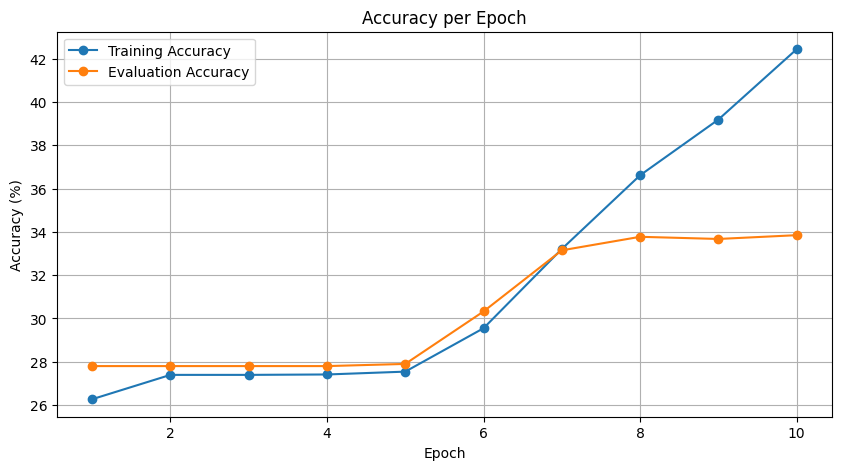

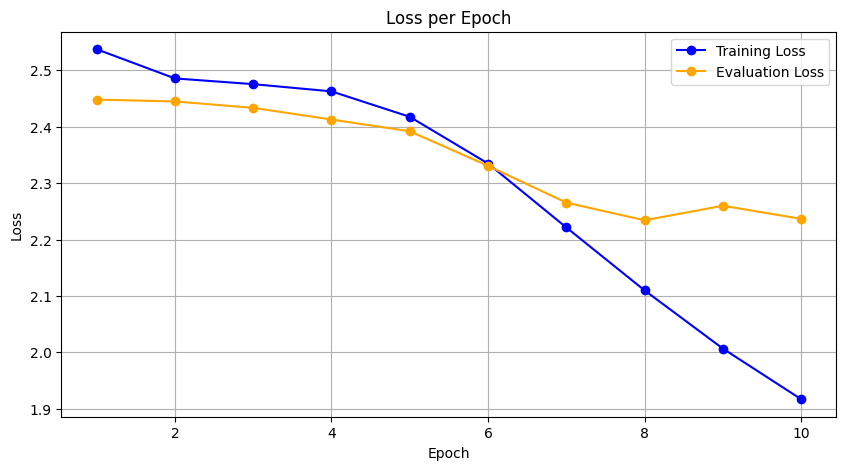

In [124]:
import matplotlib.pyplot as plt

# Plot Training and Evaluation Metrics
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), epoch_acc, label="Training Accuracy", marker='o')
plt.plot(range(1, EPOCHS + 1), epoch_eval_acc, label="Evaluation Accuracy", marker='o')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), epoch_ls, label="Training Loss", marker='o', color='blue')
plt.plot(range(1, EPOCHS + 1), epoch_eval_ls, label="Evaluation Loss", marker='o', color='orange')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

## Saving the Trained Model Artifacts for inference

In [ ]:
# Saving the files for re-use

output_model_file = './models/pytorch_distilbert_news.bin'
output_vocab_file = './models/vocab_distilbert_news.bin'

model_to_save = model
torch.save(model_to_save, output_model_file)
tokenizer.save_vocabulary(output_vocab_file)

print('All files saved')
print('This tutorial is completed')